# 1. Introduction

The NIPS conference (Neural Information Processing Systems) is one of the most prestigious yearly events in the machine learning community. At each NIPS conference, a large number of research papers are published. Over 50,000 PDF files were automatically downloaded and processed to obtain a dataset on various machine learning techniques. These papers discuss a wide variety of topics in machine learning, from neural networks to optimization methods and many more. 

First, I will explore the CSV file to determine what type of data I can use for the analysis and how it is structured. A research paper typically consists of a title, an abstract and the main text. Other data such as figures and tables were not extracted from the PDF files. Each paper discusses a novel technique or improvement. In this analysis, I will focus on analyzing these papers with natural language processing methods.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import re

papers = pd.read_csv('../input/papers.csv')
papers.head()

,id,year,title,event_type,pdf_name,abstract,paper_text
0,1,1987,Self-Organization of Associative Database and ...,NaN,1-self-organization-of-associative-database-an...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,10,1987,A Mean Field Theory of Layer IV of Visual Cort...,NaN,10-a-mean-field-theory-of-layer-iv-of-visual-c...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,100,1988,Storing Covariance by the Associative Long-Ter...,NaN,100-storing-covariance-by-the-associative-long...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1000,1994,Bayesian Query Construction for Neural Network...,NaN,1000-bayesian-query-construction-for-neural-ne...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1001,1994,"Neural Network Ensembles, Cross Validation, an...",NaN,1001-neural-network-ensembles-cross-validation...,Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


For the analysis of the papers, I am only interested in the text data associated with the paper as well as the year the paper was published in.

I will analyze this text data using natural language processing. Since the file contains some metadata such as id's and filenames, it is necessary to remove all the columns that do not contain useful text information.

In [2]:
papers = papers.drop(["id", "event_type", "pdf_name"], axis = 1)
papers.head()

,year,title,abstract,paper_text
0,1987,Self-Organization of Associative Database and ...,Abstract Missing,767\n\nSELF-ORGANIZATION OF ASSOCIATIVE DATABA...
1,1987,A Mean Field Theory of Layer IV of Visual Cort...,Abstract Missing,683\n\nA MEAN FIELD THEORY OF LAYER IV OF VISU...
2,1988,Storing Covariance by the Associative Long-Ter...,Abstract Missing,394\n\nSTORING COVARIANCE BY THE ASSOCIATIVE\n...
3,1994,Bayesian Query Construction for Neural Network...,Abstract Missing,Bayesian Query Construction for Neural\nNetwor...
4,1994,"Neural Network Ensembles, Cross Validation, an...",Abstract Missing,"Neural Network Ensembles, Cross\nValidation, a..."


In order to understand how the machine learning field has recently exploded in popularity, I will begin by visualizing the number of publications per year.

By looking at the number of published papers per year, we can understand the extent of the machine learning 'revolution'! Typically, this significant increase in popularity is attributed to the large amounts of compute power, data and improvements in algorithms.

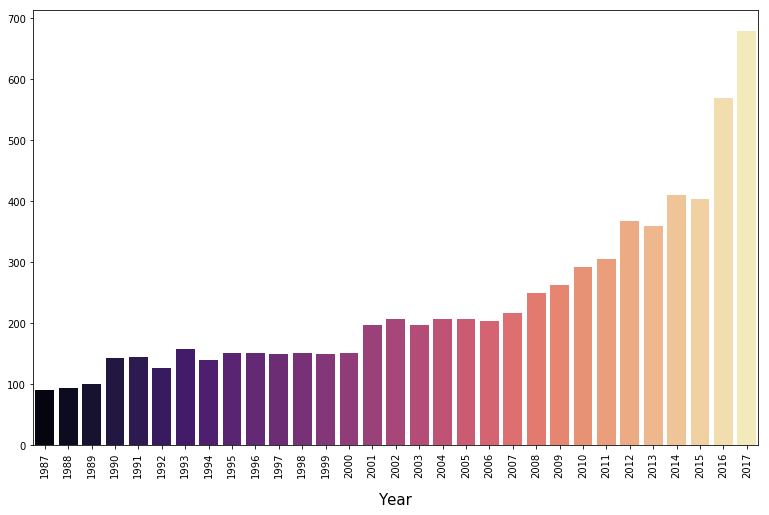

In [3]:
groups = papers.groupby('year')
counts = groups.size()

plt.figure(figsize = (13, 8))
ax = sns.barplot(counts.index, counts.values, palette=("magma"))
ax.set_xlabel("Year",fontsize = 15, labelpad = 15)
plt.xticks(rotation = 90)
plt.show()

# 2. Pre-processing the data

Let's now analyze the titles of the different papers to identify machine learning trends. First, I will perform some simple preprocessing on the titles in order to make them more amenable for analysis. I will use a regular expression to remove any punctuation in the title. Then I will perform lowercasing. I'll then print the titles of the first rows before and after applying the modification.

In [4]:
display(papers['title'].head())

papers['title_processed'] = papers['title'].map(lambda x: re.sub('[,\.!?]', '', x))
papers['title_processed'] = papers['title_processed'].map(str.lower)

display(papers['title_processed'].head())

0    Self-Organization of Associative Database and ...
1    A Mean Field Theory of Layer IV of Visual Cort...
2    Storing Covariance by the Associative Long-Ter...
3    Bayesian Query Construction for Neural Network...
4    Neural Network Ensembles, Cross Validation, an...
Name: title, dtype: object

0    self-organization of associative database and ...
1    a mean field theory of layer iv of visual cort...
2    storing covariance by the associative long-ter...
3    bayesian query construction for neural network...
4    neural network ensembles cross validation and ...
Name: title_processed, dtype: object

The main text analysis method that I will use is latent Dirichlet allocation (LDA). LDA is able to perform topic detection on large document sets, determining what the main 'topics' are in a large unlabeled set of texts. A 'topic' is a collection of words that tend to co-occur often. The hypothesis is that LDA might be able to clarify what the different topics in the research titles are. These topics can then be used as a starting point for further analysis.

LDA does not work directly on text data. First, it is necessary to convert the documents into a simple vector representation. This representation will then be used by LDA to determine the topics. Each entry of a 'document vector' will correspond with the number of times a word occurred in the document. In conclusion, I will convert a list of titles into a list of vectors, all with length equal to the vocabulary. For example, *'Analyzing machine learning trends with neural networks.'* would be transformed into <code>[1, 0, 1, ..., 1, 0]</code>.

I'll then plot the 10 most common words based on the outcome of this operation (the list of document vectors).

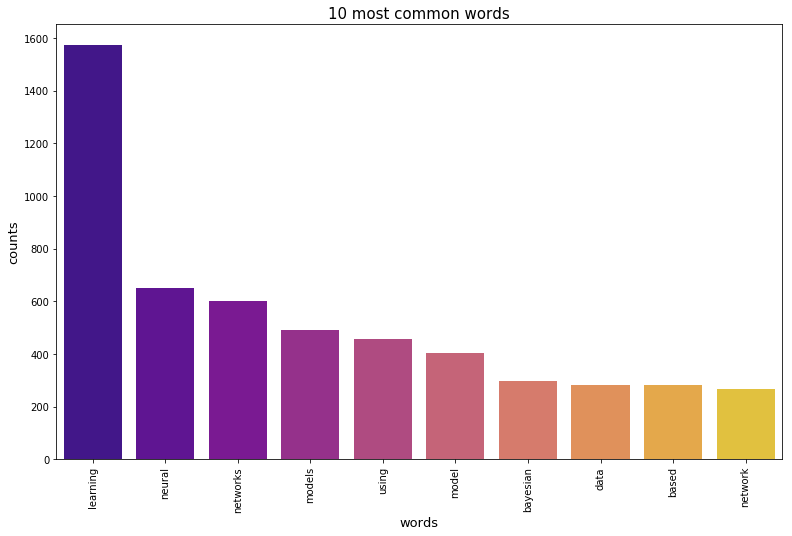

In [5]:
from sklearn.feature_extraction.text import CountVectorizer

def plot_10_most_common_words(count_data, count_vectorizer):
    words = count_vectorizer.get_feature_names()
    total_counts = np.zeros(len(words))
    for t in count_data:
        total_counts += t.toarray()[0]
    
    count_dict = (zip(words, total_counts))
    count_dict = sorted(count_dict, key=lambda x:x[1], reverse=True)
    words = [w[0] for w in count_dict[0:10]]
    counts = [w[1] for w in count_dict[0:10]]
    x_pos = np.arange(len(words))

    sns.barplot(x_pos, counts, palette=("plasma"))
    plt.xticks(x_pos, words, rotation = 90) 
    plt.xlabel('words', fontsize = 13)
    plt.ylabel('counts', fontsize = 13)
    plt.title('10 most common words', fontsize = 15)
    plt.show()
    
    return dict(count_dict)

count_vectorizer = CountVectorizer(stop_words = 'english')
count_data = count_vectorizer.fit_transform(papers['title_processed'])

plt.figure(figsize = (13, 8))
count_dict = plot_10_most_common_words(count_data, count_vectorizer)

Since most cells in the matrix <code>count_data</code> will be zero, I am interested in knowing what percentage of cells contain non-zero values. Sparsicity is nothing but the percentage of non-zero datapoints in the document-word matrix.

In [6]:
data_dense = count_data.todense()
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

Sparsicity:  0.11346205679154692 %


Finally, I will analyze the research titles using LDA.

# 3. Latent Dirichlet Allocation and GridSearch

While there are many different analyses one can do using LDA, I will only focus on finding the optimal number of topics from this data.

Typically, one calculates the 'perplexity' metric to determine which number of topics is best and iterate over different amounts of topics until the lowest 'perplexity' is found. A model with higher log-likelihood and lower perplexity (exp(-1. * log-likelihood per word)) is considered to be good.

To find the best model, I will use GridSearch. The most important tuning parameter for LDA models is n_components (number of topics). The grid search constructs multiple LDA models for all possible combinations of param values in the param_grid dict. So, this process can consume a lot of time and resources.

In [7]:
from sklearn.model_selection import GridSearchCV
from sklearn.decomposition import LatentDirichletAllocation

import warnings
warnings.simplefilter("ignore", FutureWarning)

search_params = {'n_components': [20, 25, 30, 35], 'max_iter': [10, 20, 50]}
lda = LatentDirichletAllocation()
model = GridSearchCV(lda, cv = None, param_grid = search_params)
model.fit(count_data) #Takes a long time to run

GridSearchCV(cv=None, error_score='raise-deprecating',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='batch', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=None, n_topics=None, perp_tol=0.1,
             random_state=None, topic_word_prior=None,
             total_samples=1000000.0, verbose=0),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'n_components': [20, 25, 30, 35], 'max_iter': [10, 20, 50]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

Now let us have a look at the parameters of best model that came out of GridSearch.

In [8]:
best_lda_model = model.best_estimator_

print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(count_data))

Best Model's Params:  {'max_iter': 50, 'n_components': 20}
Best Log Likelihood Score:  -163645.71711602304
Model Perplexity:  2507.1818879214834


As a last step, I will plot the <code>log-likelihood</code> scores against <code>num_topics</code>. It clearly shows number of topics = 20 has better scores. And <code>max_iter</code> of 50 outperforms both 10 and 20.

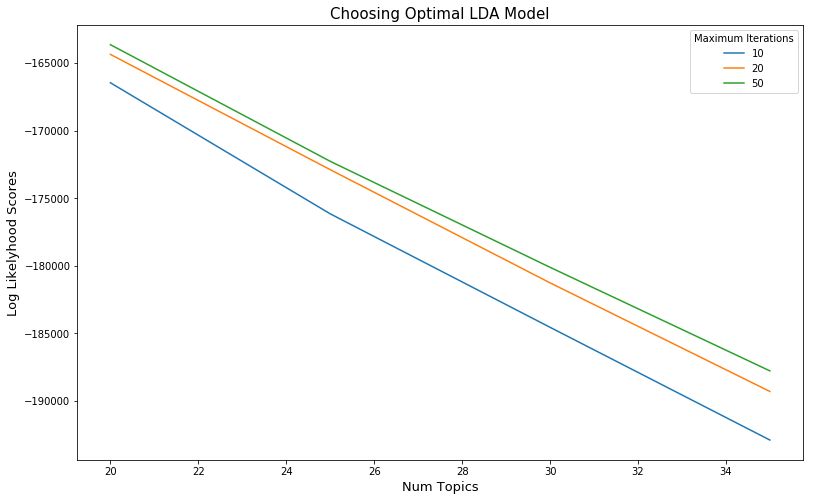

In [9]:
n_topics = [20, 25, 30, 35]
results = pd.DataFrame(model.cv_results_)
logl_10 = (results['mean_test_score'][i] for i in range(len(results)) if results['params'][i]['max_iter'] == 10)
logl_20 = (results['mean_test_score'][i] for i in range(len(results)) if results['params'][i]['max_iter'] == 20)
logl_50 = (results['mean_test_score'][i] for i in range(len(results)) if results['params'][i]['max_iter'] == 50)

plt.figure(figsize=(13, 8))
sns.lineplot(n_topics, list(logl_10), label='10')
sns.lineplot(n_topics, list(logl_20), label='20')
sns.lineplot(n_topics, list(logl_50), label='50')
plt.title("Choosing Optimal LDA Model", fontsize = 15)
plt.xlabel("Num Topics", fontsize = 13)
plt.ylabel("Log Likelyhood Scores", fontsize = 13)
plt.legend(title='Maximum Iterations', loc = 'best')
plt.show()

To see further analysis of this data, take a look at [NLP gensim](https://github.com/gargimaheshwari/NLP-gensim).